In [1]:
import os 
dir_primary = 'F:/UrbanDataProject/land_surface_temperature/code/analysis'
# os.chdir('/home/tml/research/land_surface_temperature/code/analysis')
os.chdir(dir_primary)
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
code_dir = os.getcwd()
os.chdir('../..')


# Explore data and transform

In [2]:
cities = ['bal', 'por', 'det', 'phx']
# import data
grid_size = 100
df = import_data(grid_size)

# Train on three cities, test on the fourth

In [3]:
loss = regression_cityholdouts(df, cities)

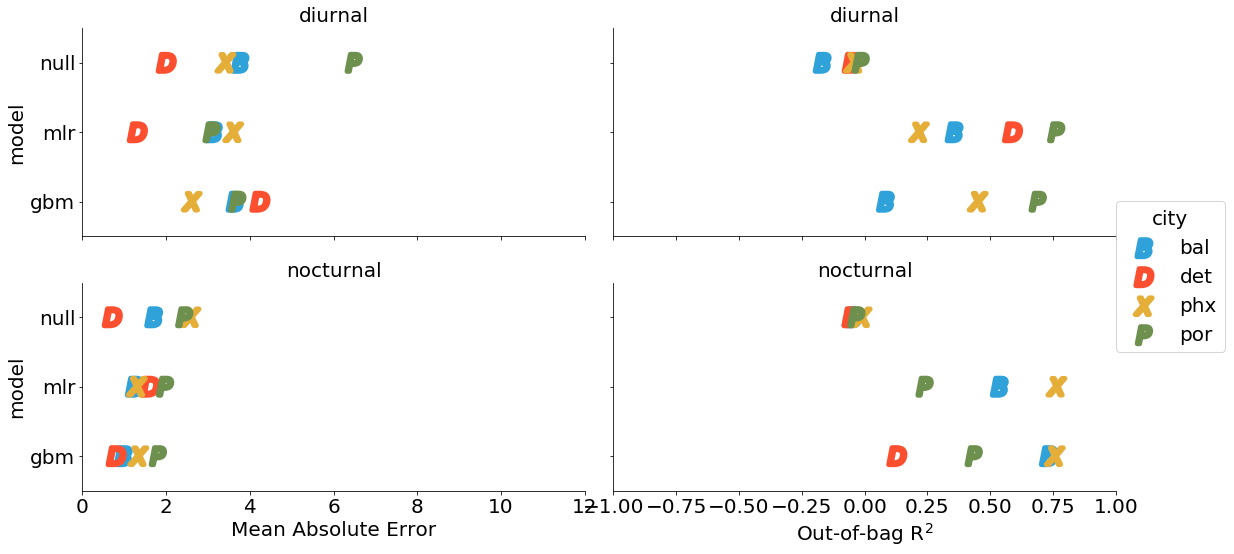

In [4]:
plot_holdout_points(loss)

# Full holdout

In [3]:
sim_num = 50 # number of holdouts

In [5]:
regressions(df, cities, sim_num)

In [9]:
loss = pd.read_csv('data/regression/holdout_results.csv', index_col=[0,1],header=[0,1], skipinitialspace=True,keep_default_na=False )
loss.reorder_levels(['city', 'model'])
loss.head()

time         diurnal           nocturnal          
loss             mae        r2       mae        r2
model city                                        
null  0     3.903844 -0.000093  2.166495 -0.002654
mlr   0     1.372562  0.879916  0.920431  0.816313
gbm   0     1.059313  0.927427  0.643436  0.912887
null  1     3.691109 -0.013976  2.072957 -0.003806
mlr   1     1.372518  0.850685  0.929556  0.798502

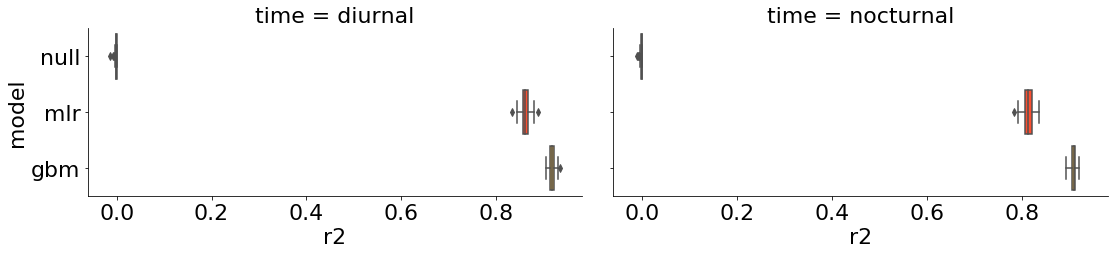

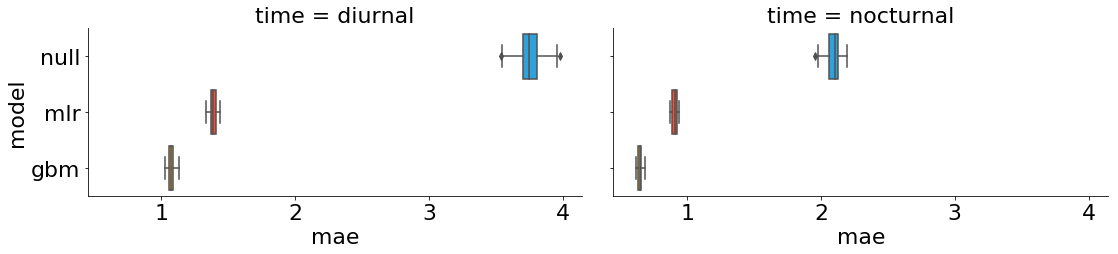

In [6]:
loss = pd.read_csv('data/regression/holdout_results.csv', index_col=[0,1],header=[0,1], skipinitialspace=True,keep_default_na=False )
loss.reorder_levels(['city', 'model'])#
for error_type in ['r2', 'mae']:
    loss_type = loss.copy()
    loss_type = loss_type.xs(error_type, axis=1, level=1)
    loss_type = loss_type.unstack(level=0)
    loss_type = loss_type.unstack(level=0)
    loss_type = pd.DataFrame(loss_type).T
    loss_type = pd.melt(loss_type)
    loss_type[error_type] = loss_type['value']
    # print(loss_type)
    five_thirty_eight = [
        "#30a2da",
        "#fc4f30",
        "#e5ae38",
        "#6d904f",
        "#8b8b8b",
    ]
    sns.set_palette(five_thirty_eight)
    mpl.rcParams.update({'font.size': 22})
    g = sns.factorplot(orient="h", x="time", y=error_type, col="time", hue = 'model', data=loss_type, kind="box", order=['null','mlr','gbm'], aspect=2, palette = five_thirty_eight)
    for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
        if i>5:
            if error_type=='r2':
                ax.set_xlabel('Out-of-bag R$^2$')
            else:
                ax.set_xlabel('Mean Absolute Error')
    for i, ax in enumerate(g.axes.flat):
        i = 0
        for patch in ax.artists:
            patch.set_facecolor(five_thirty_eight[i])
            i += 1

In [8]:
loss.head()

time         diurnal           nocturnal          
loss             mae        r2       mae        r2
model city                                        
null  0     3.673556 -0.001735  2.058729 -0.004228
mlr   0     1.024599  0.918242  0.746473  0.874677
gbm   0     0.899464  0.934383  0.566048  0.927620
null  1     3.294465 -0.081752  1.588520 -0.055377
mlr   1     1.042460  0.844391  0.736772  0.770434

In [5]:
plot_holdouts(sim_num)

ValueError: Length of values does not match length of index

# Feature Selection

In [ ]:
loop_variable_selection(df, cities)

# Post variable selection, look at change in error rates

In [ ]:
import os
os.chdir(dir_primary)
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
import pickle
with open('../../data/variable_selection.pkl', 'rb') as f:
        vars_forward = pickle.load(f)
cities = ['bal', 'por', 'det', 'phx', 'all']
range_variables = list(range(1,vars_forward['night']['bal'].shape[0]+1))
for city in cities:
    for period in ['night', 'day']:
        plt.plot(range_variables,vars_forward[period][city]['mae'], label = period)
    plt.ylabel('Mean absolute error, \naveraged over 25 holdouts')
    plt.xlabel('Number of variables')
    plt.legend(loc='upper right')
    plt.title(city)
    plt.savefig('../../fig/working/regression/MAE_vars_{}.pdf'.format(city), format='pdf', dpi=1000, transparent=True)
    plt.show()

In [ ]:
vars_forward['night']['det']

# which variables
Based on the output of the variable selection, I want to look at the variables that were included first, for each of the different models and times

In [ ]:
# import the vars_forward object
import os
os.chdir(dir_primary)
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

with open('../../data/variable_selection.pkl', 'rb') as f:
        vars_forward = pickle.load(f)

# create a database with the variable names
cities = ['bal', 'por', 'det', 'phx', 'all']
times = ['night', 'day']
db_var = pd.DataFrame()
for city in cities:
    for day in times:
        db_var['{}-{}'.format(city,day)] = vars_forward[day][city]['variables']
db_var

In [ ]:
# to select the variables, i'm going to calculate the median index of each of them
var_list = pd.DataFrame(index=db_var['bal-night'].values)
for var in var_list.index:
    for city in cities:
        for day in times:
            col = '{}-{}'.format(city,day)
            var_list.loc[var, col] = np.where(db_var[col] == var)[0][0]
# make the day median, night median, and overall median. sort by overall median
var_list['median'] = var_list.median(axis=1)
var_list['mean'] = var_list.mean(axis=1)
var_list['median-day'] = var_list[[col for col in var_list.columns if 'day' in col]].median(axis=1)
var_list['median-night'] = var_list[[col for col in var_list.columns if 'night' in col]].median(axis=1)

var_list = var_list.sort_values(by='mean')
var_list

based on this I will probably take the first 6. although, potential need to think about the day vs night. but these effects should show when i compare the partial dependence plots

# Run regression with this variable subset and create the variable importance and partial dependence

In [ ]:
import os
os.chdir(dir_primary)
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
code_dir = os.getcwd()
os.chdir('../..')

# loop cities and all
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(cities)
# based on the results of the variable selection, rerun the regression and
# create the variable importance plots
vars_selected = ['tree_mean', 'ndvi_mean_mean', 'alb_mean_mean', 'elev_min', 'alb_mean_min_sl', 'elev_max']    
reg_gbm, X_train = full_gbm_regression(df, cities, vars_selected)

In [ ]:
# plot the variable importance
importance_order = plot_importance(reg_gbm, cities, show_plot = True)

In [ ]:
# plot the partial dependence plots
plot_dependence(importance_order, reg_gbm, cities, X_train,vars_selected, show_plot = True)

In [ ]:
# two way partial dependence
cities =  ['bal', 'por', 'det', 'phx']
# cities.append('all')
# plot setup (surely this can be a function)
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",]
sns.set_palette(five_thirty_eight)
mpl.rcParams.update({'font.size': 20})
# init subplots (left is nocturnal, right is diurnal)
fig, axes = plt.subplots(len(cities), 2, figsize = (15,30), sharey=True, sharex=True)
# loop through the top n variables by nocturnal importance
feature = 0
features = ['']
levels_set = False
for city in cities:
    left_right = 0
    for period in ['nocturnal', 'diurnal']:
        gbm = reg_gbm[period][city]
        # calculate the partial dependence
        pdp, ax = partial_dependence(gbm, (0, 1), X = X_train[city],
                                grid_resolution = 50)
        # get data
        XX, YY = np.meshgrid(ax[0], ax[1])
        Z = pdp[0].reshape(list(map(np.size, ax))).T
        # add the line to the plot
        CS = axes[feature, left_right].contour(XX,YY,Z, levels=np.arange(-8,4,1))
        axes[feature, left_right].clabel(CS, inline=True, fontsize=8)
        # title and axis labels
        axes[feature, left_right].set_title('{} {}'.format(period,city))
        plt.xlabel('Canopy cover')
        plt.ylabel('NDVI')
        left_right += 1
    feature += 1


In [ ]:
np.linspace(-8,0.5,4)
np.arange(-8,4,0.5)

In [ ]:
reg_gbm[period][city]

In [ ]:
importance_order

In [ ]:
# debug the elevation issue - is it scaled correctly and doing what I think it is?

vars_all = df.columns.values
vars_elev = [i for i in vars_all if 'elev' in i]

df[vars_elev+['city']]
df_elev = df.copy()
# plot the elevation histograms
sns.violinplot(y = 'elev_mean', x ='city', data=df_elev)
plt.show()

# subtract the mean off all of these 
medians = df_elev.groupby(df_elev.city)[vars_elev].median().median(axis=1)
for city in ['bal', 'phx', 'por', 'det']:
    df_elev.loc[df_elev['city']==city,vars_elev] = df_elev.loc[df_elev['city']==city,vars_elev] - medians[city]
    
sns.violinplot(y = 'elev_mean', x ='city', data=df_elev)
plt.show()

# now scale
elev_max = np.max(df_elev[vars_elev].values.max())
elev_min = np.min(df_elev[vars_elev].values.min())
df_elev.loc[:,vars_elev] = (df_elev.loc[:,vars_elev] - elev_min)/(elev_max-elev_min)
sns.violinplot(y = 'elev_mean', x ='city', data=df_elev)
plt.show()
print(elev_min, elev_max)